In [ ]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import IPython
import pickle
import itertools
from scipy.sparse import csc_matrix,csr_matrix
import os

# spatial Gillespie code 
`run_spatial_Gillespie()` modified from previous version to allow rates to depend on space and to include a memory saving option for systems with large configuration matrices
`generate_connectivity_matrix()` modified from previous version to allow non-square rectangular lattices

In [ ]:
def generate_connectivity_matrix(space_shape): 
    """
    Generates a connectivity matrix for a cubic arrangement of SVs in a specified number of dimensions

    Parameters
    ----------
    space_shape : 1D array
        Specifies the size of each dimension of the space
        `len(space_shape)` specifies the number of dimensions in the space    

    Returns
    -------
    connectivity : 2D array
        Matrix where each row corresponds to a single SV and specifies the indices of the neighbouring SVs
    """
    space_shape = np.array(space_shape) # ensure space_shape is a numpy array
    dim = len(space_shape)
    n_SV = np.prod(space_shape)
    successive_shape_products = np.array([np.prod(space_shape[0:k]) for k in range(dim)])
    connectivity = np.zeros((n_SV, 2 * dim), dtype=int)
    axes = [range(space_shape[k]) for k in range(dim)]
    for coords in itertools.product(*axes):
        i = np.dot(coords, successive_shape_products)  # x*1 + y*nx (+ z*nx*ny + ... for all the dimensions)

        # include closed boundaries by connecting SVs to themselves if travelling in that direction would otherwise take you out of the grid
        connectivity[i] = np.array([[i + successive_shape_products[k] if coords[k] != space_shape[k] - 1 else i,
                                     i - successive_shape_products[k] if coords[k] != 0 else i] 
                                    for k in range(dim)]
                                   ).flatten()
    return connectivity


def run_spatial_Gillespie(reaction_rate_function, reaction_update_function, connectivity, configuration, n_steps=100, diffusion_constants=None,SV_size=1.0,memory_saving=False,save_directory = None, sampling_interval = 1, sparse_matrix = False):
    """
    Simulate a stochastic reaction-diffusion system by discretising the space into subvolumes (SVs) and implementing the spatial next reaction method from the paper "Mesoscopic reaction-diffusion in
intracellular signaling" by Johan Elf, Andreas Doncic, Mans Ehrenberg (doi:10.1117/12.497009)

    Parameters
    ----------
    reaction_rate_function : callable(concs,SV)
        Computes the reaction rate for each reaction given an array containing the concentration of each species and the SV number (which could be used for inferring spatial position)

    reaction_update_function : callable(reaction_number,configuration_row)
        Updates the array containing the number of molecules of each species (`configuration_row`) based on the specified `reaction_number`

    connectivity : 2D array
        Matrix where each row corresponds to a single SV and specifies the indices of the neighbouring SVs

    configuration : 2D array
        Matrix where each row corresponds to a single SV and specifies the initial number of molecules of each species in that SV
    
    n_steps : int, optional
        Number of time steps to simulate
    
    diffusion_constants : 1D array, optional
        Diffusion constant (float) for each species
    
    SV_size : float, optional
        Side length of a subvolume
    
    memory_saving : bool, optional
        Allows the simulation to work with very large configuration matrices without filling all the available memory
        If True:
            saves the configuration matrix to storage at each time step as unsigned 8-bit integers
            returns None as the second return value
    
    save_directory : str, optional
        Must be specified if memory_saving is True
        Specifies the directory to which the pickled configuration matrices will be saved
        Should end in a forward slash

    sampling_interval : int, optional
        Interval at which the state of the simulation is sampled

    sparse_matrix : bool, optional
        Allows configuration matrices that are mostly 0 to be stored more compactly
        If True:
            saves each configuration matrix as a scipy.sparse.csc_matrix object, either in storage or in configuration_history depending on the value of memory_saving
    
    
    Returns
    -------
    event_time_history : array, shape (n_steps)
        Array containing the time of each reaction-diffusion event

    configuration_history : array, shape (n_steps,configuration.shape[0],configuration.shape[1])
        Array containing the number of molecules of each species in each SV at each time step
        None if memory_saving is True
    """
    NUM_DIFFUSIONS = 0
    intensity = reaction_rate_function
    react = reaction_update_function
    connectivity = connectivity.astype(int)
    if memory_saving:
        configuration = configuration.astype(np.uint8) # conversion to 8-bit unsigned integer to save memory
    else:
        configuration = configuration.astype(int)

    M = configuration.shape[1]  # number of species in the system
    R = len(intensity(np.ones(M),0))  # number of reactions
    n_SV = configuration.shape[0]
    if diffusion_constants is None: 
        diffusion_constants = np.ones(M,dtype=np.float64)
    DELTA = SV_size ** 3  # volume of SV
    scaled_diffusion = diffusion_constants / SV_size ** 2  # diffusion constant per SV
    

    # history variables
    event_time_history = np.zeros(n_steps)
    if memory_saving:
        assert type(save_directory) == str
        with open(save_directory+"0", "wb") as f:
                pickle.dump(configuration,#csc_matrix(configuration), 
                            f)
    else: 
        configuration_history = np.zeros((n_steps, n_SV, M), 
                                     dtype=int)
        configuration_history[0] = configuration

    # calculate the reaction intensities and diffusion intensities for each chemical reaction for each subvolume
    reaction_intensities = np.zeros((n_SV,R))
    diffusion_intensities = np.zeros((n_SV,M))
    for SV in range(configuration.shape[0]): 
        reaction_intensities[SV] = intensity(configuration[SV].T / DELTA, SV).T
        diffusion_intensities[SV] = scaled_diffusion * configuration[SV]
    r = np.sum(reaction_intensities, 1)
    s = np.sum(diffusion_intensities, 1)
    r_plus_s = r + s

    t = np.random.exponential(1 / r_plus_s)
    SVs = np.arange(n_SV)  # 0 indexed
    # Make the event queue array by first making the Q-array to specify the position of each
    Q = np.argsort(t)
    event_queue = np.vstack((SVs[Q], t[Q])).T.tolist()

    event_time_history[0] = event_queue[0][1]  # record time of next event

    for i in range(1, n_steps):
        active_SV = int(event_queue[0][0])  # index of next SV to have a reaction
        while r_plus_s[active_SV] == 0:  # if no reactions and no diffusion possible, move on to the next SV in the event queue
            event_queue = np.delete(event_queue, 0, axis=0)
            active_SV = int(event_queue[0][0])

        rand = np.random.uniform(0, 1)
        reaction_threshold = r[active_SV] / (r_plus_s[active_SV])
        if rand < reaction_threshold:  # reaction event
            # calculate the probability of each reaction
            P = reaction_intensities[active_SV]
            P /= np.sum(P)  # ensure probabilities sum to 1
            # choose which reaction occurs
            reaction_number = np.random.choice(np.arange(R), p=P)
            # update row in configuration matrix corresponding to reacting SV
            configuration[active_SV] = react(reaction_number, configuration[active_SV])
            # recalculate rates for active SV and destination SV
            reaction_intensities[active_SV] = intensity(configuration[active_SV].T / DELTA, active_SV).T
            diffusion_intensities[active_SV] = scaled_diffusion * configuration[active_SV]
            r[active_SV] = np.sum(reaction_intensities[active_SV])
            s[active_SV] = np.sum(diffusion_intensities[active_SV])
            r_plus_s[active_SV] = r[active_SV] + s[active_SV]
            # generate a new time for next reaction-diffusion event in newly updated SV
            t[active_SV] += np.random.exponential(r_plus_s[active_SV])
            # reorder the event queue to reflect updated t values
            Q = np.argsort(t)
            event_queue = np.vstack((SVs[Q], t[Q])).T.tolist()


        else:  # diffusion event
            NUM_DIFFUSIONS += 1
            # choose which species diffuses
            P = scaled_diffusion * configuration[active_SV] / s[active_SV]
            diffusing_species_index = np.random.choice(np.arange(M), p=P)
            # choose the SV to which the molecule diffuses
            destination_SV = np.random.choice(connectivity[active_SV])  # index of the SV to which the molecule diffuses
            # remove molecule from diffusing SV and add molecule to destination SV
            configuration[active_SV, diffusing_species_index] -= 1
            configuration[destination_SV, diffusing_species_index] += 1
            # recalculate rates for active SV and destination SV
            reaction_intensities[active_SV] = intensity(configuration[active_SV].T / DELTA, active_SV).T
            diffusion_intensities[active_SV] = scaled_diffusion * configuration[active_SV]
            r[active_SV] = np.sum(reaction_intensities[active_SV])
            s[active_SV] = np.sum(scaled_diffusion * configuration[active_SV])
            r_plus_s[active_SV] = r[active_SV] + s[active_SV]
            reaction_intensities[destination_SV] = intensity(configuration[destination_SV].T / DELTA, active_SV).T
            diffusion_intensities[destination_SV] = scaled_diffusion * configuration[destination_SV]
            r[destination_SV] = np.sum(reaction_intensities[destination_SV])
            s[destination_SV] = np.sum(scaled_diffusion * configuration[destination_SV])
            r_plus_s[destination_SV] = r[destination_SV] + s[destination_SV]
            # generate a new time for next reaction-diffusion event in newly updated SVs
            t[active_SV] += np.random.exponential(1 / r_plus_s[active_SV])
            t[destination_SV] += np.random.exponential(1 / r_plus_s[destination_SV])
            # reorder the event queue to reflect updated t values
            Q = np.argsort(t)
            event_queue = np.vstack((SVs[Q], t[Q])).T.tolist()

        if i % sampling_interval == 0: # record simulation state
            event_time_history[i//sampling_interval] = event_queue[0][1]  # record time of next event
            if sparse_matrix:
                configuration = csc_matrix(configuration)
                
            if memory_saving:
                with open(save_directory+str(i//sampling_interval), "wb") as f:
                    pickle.dump(configuration, f)
            else: 
                configuration_history[i//sampling_interval] = configuration
    print(NUM_DIFFUSIONS)
    return (event_time_history, configuration_history if not memory_saving else None)

# Setup

In [ ]:
def A(p,K,n=4): # activation Hill function
    return p**n/(p**n+K**n)

def R(p,K,n=4): # repression Hill function
    return K**n/(p**n+K**n)

@np.vectorize
def constrain(x): # constrain probabilities between 0 and 1
    if x < 0:
        return 0
    elif x > 1:
        return 1
    else:
        return x

In [ ]:
# Spatial parameters
space_shape = np.array([300,100])
dim = len(space_shape)
n_SV = np.prod(space_shape) # number of subvolumes composing the space
connectivity = generate_connectivity_matrix(space_shape)
P1_cost_centre = (0.1*space_shape[0],0.5*space_shape[1])
P2_cost_centre = (0.9*space_shape[0],0.5*space_shape[1])

MAX_PLASMID_STATES = 60 # number of possible values each plasmid can take starting from 0

# General simulation parameters
Kd = np.array([100,100],#,100],
            dtype=np.float64)
Kc_functions = [lambda x,y: 10+2000*np.exp(-0.00005*((x-P1_cost_centre[0])**2+(y-P1_cost_centre[1])**2)),
                lambda x,y: 10+2000*np.exp(-0.00005*((x-P2_cost_centre[0])**2+(y-P2_cost_centre[1])**2))]
Kb_functions = [lambda x,y: 0.5, lambda x,y: 0.5]
g = 10000000
d = 1
r2 = 1
C = 10000
S = 10000
ptot = 50
dup_ori = True

In [ ]:
# Reaction scheme - cells and plasmids with spatial dependence
# Cells can have between 0 and 59 of each plasmid (60 different plasmid numbers)
# Each combination of plasmid numbers is a distinct species
# Thus for a 2 plasmid system there are 3600 different possible species
""" reactions:
plasmid replication (2 reactions per P1,P2 combination)
-------------------
duplicate oris:
    r2*P1*C_[P1,P2]*(1-(P1+P2)/ptot): C_[P1,P2] -> C_[P1+1,P2]
    r2*P2*C_[P1,P2]*(1-(P1+P2)/ptot): C_[P1,P2] -> C_[P1,P2+1]
different oris:
    r2*P1*C_[P1,P2]*(1-P1/ptot): C_[P1,P2] -> C_[P1+1,P2]
    r2*P2*C_[P1,P2]*(1-P2/ptot): C_[P1,P2] -> C_[P1,P2+1]

cell division (1 reaction per P1,P2 combination)
-------------
P1_prime = np.random.binomial(P1,0.5)
P2_prime = np.random.binomial(P2,0.5)
N = np.sum(C_) # total number of cells
# C = carrying capacity
   C_[P1,P2]*g*(1-N/C)*A(Kb[0],P1)*R(Kc[0],P1)*A(Kb[1],P2)*R(Kc[1],P2)  : C_[P1,P2] -> C_[P1_prime,P2_prime] + C_[P1-P1_prime,P2-P2_prime]

cell death (1 reaction per P1,P2 combination)
----------
   C_[P1,P2]*((N**2/(N**2 + S**2)) + d*A(P1,Kd[0]) + d*A(P2,Kd[1]) : C_[P1,P2] -> 0

Total number of reactions: 4*(60)**2 = 14400
"""

reaction1_min_index = 0
reaction1_max_index = MAX_PLASMID_STATES**2
reaction2_min_index = MAX_PLASMID_STATES**2   
reaction2_max_index = 2*MAX_PLASMID_STATES**2
reaction3_min_index = 2*MAX_PLASMID_STATES**2
reaction3_max_index = 3*MAX_PLASMID_STATES**2
reaction4_min_index = 3*MAX_PLASMID_STATES**2
reaction4_max_index = 4*MAX_PLASMID_STATES**2

def intensity(concs,SV): # "reaction intensity" = rate in units of s^-1 - equal to "a_{j \alpha}" in the paper 

    # Initialisation
    C_ = concs.reshape(MAX_PLASMID_STATES,MAX_PLASMID_STATES) # reshape concs array to 2D so that C_[P1,P2] indexing can be used
    P1_grid,P2_grid = np.meshgrid(np.arange(0,MAX_PLASMID_STATES),np.arange(0,MAX_PLASMID_STATES))
    rates = np.zeros(4*MAX_PLASMID_STATES**2,dtype=np.float64)

    # Calculate Kb and Kc at the current SV by inferring spatial position (assumes 2 dimensions)
    assert len(space_shape) == 2
    x = SV % space_shape[0]
    y = SV // space_shape[0]
    Kb = np.array([f(x,y) for f in Kb_functions])
    Kc = np.array([f(x,y) for f in Kc_functions])
    
    # Plasmid replication reactions
    if dup_ori:
        reaction1_function = lambda P1,P2: r2*P1*C_[P1,P2]*(1-(P1+P2)/ptot) 
        reaction1_rates = constrain(reaction1_function(P1_grid,P2_grid)).flatten()
        rates[reaction1_min_index:reaction1_max_index] = reaction1_rates
        reaction2_function = lambda P1,P2: r2*P2*C_[P1,P2]*(1-(P1+P2)/ptot) 
        reaction2_rates = constrain(reaction2_function(P1_grid,P2_grid)).flatten()
        rates[reaction2_min_index:reaction2_max_index] = reaction2_rates
    else:
        reaction1_function = lambda P1,P2: r2*P1*C_[P1,P2]*(1-P1/(ptot/2)) 
        reaction1_rates = constrain(reaction1_function(P1_grid,P2_grid)).flatten()
        rates[reaction1_min_index:reaction1_max_index] = reaction1_rates
        reaction2_function = lambda P1,P2: r2*P2*C_[P1,P2]*(1-P2/(ptot/2))
        reaction2_rates = constrain(reaction2_function(P1_grid,P2_grid)).flatten()
        rates[reaction2_min_index:reaction2_max_index] = reaction2_rates
    
    # Cell division reaction
    N = np.sum(C_) # total number of cells
    reaction3_function = lambda P1,P2: C_[P1,P2]*g*(1-N/C)*A(Kb[0],P1)*R(Kc[0],P1)*A(Kb[1],P2)*R(Kc[1],P2)
    reaction3_rates = constrain(reaction3_function(P1_grid,P2_grid)).flatten()
    rates[reaction3_min_index:reaction3_max_index] = reaction3_rates

    # Cell death reaction
    reaction4_function = lambda P1,P2: C_[P1,P2]*((N**2/(N**2 + S**2)) + d*A(P1,Kd[0]) + d*A(P2,Kd[1]))
    reaction4_rates =  constrain(reaction4_function(P1_grid,P2_grid)).flatten()
    rates[reaction4_min_index:reaction4_max_index] = reaction4_rates

    return rates
    
def react(reaction_number,configuration_row): # reaction_number starts from 0

    C_ = configuration_row.reshape(MAX_PLASMID_STATES,MAX_PLASMID_STATES) # reshape configuration_row array to 2D so that C_[P1,P2] indexing can be used
    
    if reaction_number < reaction1_max_index: 
        P1 = (reaction_number // reaction1_max_index) % MAX_PLASMID_STATES
        P2 = (reaction_number // reaction1_max_index) // MAX_PLASMID_STATES
        # Plasmid 1 replication
        if P1+1 < MAX_PLASMID_STATES: # only allow replication if the new plasmid copy number does not exceed the maximum
            C_[P1,P2] -= 1
            C_[P1+1,P2] += 1
        else:
            print("plasmid 1 replication beyond maximum attempted")
    elif reaction_number < reaction2_max_index:
        P1 = (reaction_number // reaction2_max_index) % MAX_PLASMID_STATES
        P2 = (reaction_number // reaction2_max_index) // MAX_PLASMID_STATES
        # Plasmid 2 replication
        # C_[P1,P2] -> C_[P1,P2+1]
        if P2+1 < MAX_PLASMID_STATES: # only allow replication if the new plasmid copy number does not exceed the maximum
            C_[P1,P2] -= 1
            C_[P1,P2+1] += 1
        else:
            print("plasmid 2 replication beyond maximum attempted")
        
    elif reaction_number < reaction3_max_index:
        P1 = (reaction_number // reaction3_max_index) % MAX_PLASMID_STATES
        P2 = (reaction_number // reaction3_max_index) // MAX_PLASMID_STATES
        # Cell division
        # partition plasmids between daughter cells binomially
        P1_prime = np.random.binomial(P1,0.5)
        P2_prime = np.random.binomial(P2,0.5)
        # C_[P1,P2] -> C_[P1_prime,P2_prime] + C_[P1-P1_prime,P2-P2_prime]
        C_[P1,P2] -= 1
        C_[P1_prime,P2_prime] += 1
        C_[P1-P1_prime,P2-P2_prime] += 1

    elif reaction_number < reaction4_max_index:
        P1 = (reaction_number // reaction4_max_index) % MAX_PLASMID_STATES
        P2 = (reaction_number // reaction4_max_index) // MAX_PLASMID_STATES
        # Cell death
        # C_[P1,P2] -> 0
        C_[P1,P2] -= 1
    else:
        raise Exception("Invalid reaction number")
    return C_.flatten()

# Simulation

In [ ]:
# initial state: randomly populate the space with 1000 cells each with 10 of each plasmid
configuration = np.zeros((n_SV,MAX_PLASMID_STATES**2),dtype=int)
cell_positions = np.random.choice(range(n_SV),size=200,
                                  replace=True) # allow multiple cells to occur in the same place
for position in cell_positions:
    configuration[position,100] += 1 # 100 is the index corresponding to 10 of plasmid 1 and 10 of plasmid 2
#"""
"""# random (binomially distributed) initial state
configuration = np.random.binomial(30,0.2,size=(n_SV,MAX_PLASMID_STATES**2))
#"""
""" # gaussian initial state
configuration = np.zeros((n_SV,M),dtype=int)
for x in range(side_length):
    for y in range(side_length):
        i = x + y*side_length
        configuration[i] = int(20*np.exp(-0.01*((x-side_length/2)**2 + (y-side_length/2)**2)))
#"""

' # gaussian initial state\nconfiguration = np.zeros((n_SV,M),dtype=int)\nfor x in range(side_length):\n    for y in range(side_length):\n        i = x + y*side_length\n        configuration[i] = int(20*np.exp(-0.01*((x-side_length/2)**2 + (y-side_length/2)**2)))\n#'

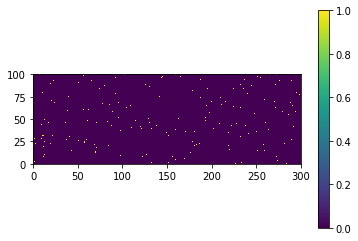

In [ ]:
plt.pcolormesh(configuration[:,100].reshape(space_shape).T)
plt.gca().set_aspect("equal")
plt.colorbar()

In [ ]:
# 11 min for n_steps = 60000 sampling_interval = 1000
# except now it takes 1 hour, so let's go to n_steps = 5000 (6min)
n_steps = 5000
sampling_interval = 100

# suppress divide by 0 warnings 
np.seterr(divide='ignore')

# set the directory where the configuration arrays will be saved in memory_saving mode
memory_saving = True
state_history_directory = "./configurations/"
try:
    os.mkdir(state_history_directory)
except FileExistsError:
    pass

# run the simulation
ts,states = run_spatial_Gillespie(intensity,react,connectivity,configuration,n_steps,
                                  diffusion_constants = 5*np.ones(MAX_PLASMID_STATES**2),
                                  memory_saving = memory_saving,save_directory=state_history_directory,
                                  sampling_interval = sampling_interval)

4946


# Data processing

In [ ]:
if states is None: # states saved in storage
    cells_data = np.zeros((n_steps,space_shape[0],space_shape[1])) # total number of cells
    p1_data = np.zeros((n_steps,space_shape[0],space_shape[1])) # total number of plasmid 1
    p2_data = np.zeros((n_steps,space_shape[0],space_shape[1])) # total number of plasmid 2
    for i in range(0,np.floor(n_steps/sampling_interval).astype(int)):
        with open(state_history_directory+str(i), "rb") as f:
            state = pickle.load(f)
        if isinstance(state,np.ndarray):
            data_i = state.reshape((space_shape[0],space_shape[1],MAX_PLASMID_STATES**2))
            cells_data[i] = np.sum(data_i,axis=2)
            for j in range(MAX_PLASMID_STATES**2):
                P1 = j % MAX_PLASMID_STATES
                P2 = j // MAX_PLASMID_STATES
                p1_data[i][:,:] += P1 * data_i[:,:,j]
                p2_data[i][:,:] += P2 * data_i[:,:,j]
        else: # sparse matrix (CSC)
            for j in range(MAX_PLASMID_STATES**2):
                frame_data = state[:,j].reshape(space_shape[0],space_shape[1])
                P1 = j % MAX_PLASMID_STATES
                P2 = j // MAX_PLASMID_STATES
                p1_data[i][:,:] += P1 * frame_data
                p2_data[i][:,:] += P2 * frame_data

elif isinstance(states,np.ndarray):
    data = states.reshape((n_steps,space_shape[0],space_shape[1],MAX_PLASMID_STATES**2))
    cells_data = np.sum(data,axis=3) # total number of cells
    p1_data = np.zeros((n_steps,space_shape[0],space_shape[1])) # total number of plasmid 1
    p2_data = np.zeros((n_steps,space_shape[0],space_shape[1])) # total number of plasmid 2
    for i in range(n_steps):
        for j in range(MAX_PLASMID_STATES**2):
            P1 = j % MAX_PLASMID_STATES
            P2 = j // MAX_PLASMID_STATES
            p1_data[i][:,:] += P1 * data[i,:,:,j]
            p2_data[i][:,:] += P2 * data[i,:,:,j]
else: # sparse matrix
    # saves memory, fast for CSC (2 minutes for n_steps = 60)
    # but extremely slow for CSR - over an hour for n_steps = 60 for 68% completion (because it's compressing rows but here it's iterating over columns)
    cells_data = sum([np.sum(state,axis=1) for state in states]) # total number of cells
    p1_data = np.zeros((n_steps,space_shape[0],space_shape[1])) # total number of plasmid 1
    p2_data = np.zeros((n_steps,space_shape[0],space_shape[1])) # total number of plasmid 2
    for i in range(n_steps):
        for j in range(MAX_PLASMID_STATES**2):
            frame_data = states[i][:,j].reshape(space_shape[0],space_shape[1])
            P1 = j % MAX_PLASMID_STATES
            P2 = j // MAX_PLASMID_STATES
            p1_data[i][:,:] += P1 * frame_data
            p2_data[i][:,:] += P2 * frame_data

```
else: # sparse matrix, should run equally fast on CSR and CSC matrices
    # saves memory but very slow - 21 minutes to run for n_steps = 60
    cells_data = sum([np.sum(state,axis=1) for state in states]) # total number of cells
    p1_data = np.zeros((n_steps,side_length,side_length)) # total number of plasmid 1
    p2_data = np.zeros((n_steps,side_length,side_length)) # total number of plasmid 2
    for i in range(n_steps):
        for j in range(n_SV):
            x = j % side_length
            y = j // side_length
            for k in range(MAX_PLASMID_STATES**2):
                P1 = k % MAX_PLASMID_STATES
                P2 = k // MAX_PLASMID_STATES
                p1_data[i][x,y] += P1 * data[i,x,y,k]
                p2_data[i][x,y] += P2 * data[i,x,y,k]
```

# Plotting

In [ ]:
# enable the animation to play 
matplotlib.rc('animation', html='jshtml')
matplotlib.rcParams['animation.embed_limit'] = 2**128 # allow for large animations

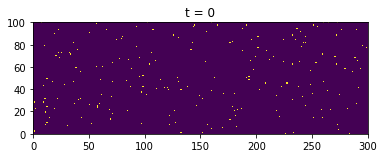

In [ ]:
# set up the figure and axes
fig, ax = plt.subplots()

def animate(i):
    ax.clear() # clear previous frame
    ax.set_title(f't = {i*sampling_interval}')
    ax.set_aspect('equal') # set 1:1 aspect ratio of the plot
    ax.pcolormesh(p1_data[i].T, # transpose because x in the simulation is vertical when plotted because of matrix indexing
                  cmap='viridis')
    
animation = FuncAnimation(fig, animate, frames=np.floor(n_steps/sampling_interval).astype(int), interval=50)

# display the animation in the IPython notebook
IPython.display.HTML(animation.to_jshtml())

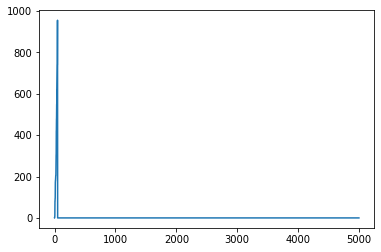

In [ ]:
# plot time over timesteps
plt.plot(np.arange(len(ts)),ts)

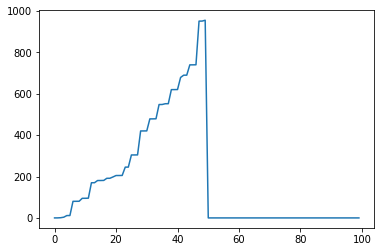

In [ ]:
# plot time over timesteps (zoomed in)
plt.plot(np.arange(100),ts[:100])

In [ ]:
# plot spatial variance over time
if states is not None:
    plt.plot(ts,np.var(states,axis=(1,2)))
else:
    print("states is None")

states is None


# Brusellator (simple example of spatial Gillespie)

### Setup

In [ ]:
# Reaction scheme 3 - Brusselator https://en.wikipedia.org/wiki/Brusselator
""" reactions:
k1a: 0 -> X
k2*[X]**2*[Y]: 2X + Y -> 3X
k3b*[X]: X -> Y
k4*[X]: X -> E
"""
def intensity(concs,SV): # "reaction intensity" = rate in units of s^-1 - equal to "a_{j \alpha}" in the paper
    conc_X,conc_Y = concs
    k1a = 1
    k2 = 1
    k3b = 3
    k4 = 1
    return np.array([
        k1a*conc_X,
        k2*conc_X**2*conc_Y,
        k3b*conc_X,
        k4*conc_X],
        dtype=np.float64) # "+0*conc_A" is so that when broadcasting over A you get an output with the shape of A for every item in the list
def react(reaction_number,configuration_row): # reaction_number starts from 0
    if reaction_number == 0: 
        configuration_row[0] += 1
    elif reaction_number == 1:
        configuration_row[0] += 1 
    elif reaction_number ==2:
        configuration_row[0] -= 1
        configuration_row[1] += 1
    elif reaction_number==3:
        configuration_row[0] -= 1
    else:
        raise Exception("Invalid reaction number")
    return configuration_row

### Simulation

In [ ]:
# run the simulation
dim = 2
side_length = 50
n_SV = side_length**dim
connectivity = generate_connectivity_matrix(n_SV,dim)
n_steps = 60000
M=2

"""
configuration = 30*np.ones((n_SV,M),dtype=int)
"""
# gaussian initial state
configuration = np.zeros((n_SV,M),dtype=int)
for x in range(side_length):
    for y in range(side_length):
        i = x + y*side_length
        configuration[i] = int(20*np.exp(-0.01*((x-side_length/2)**2 + (y-side_length/2)**2)))
#"""


# suppress divide by 0 warnings 
np.seterr(divide='ignore')

ts,states = run_spatial_Gillespie(intensity,react,connectivity,configuration,n_steps,
                                     diffusion_constants = np.array([5,5]))

### Data processing

In [ ]:
data = states.reshape((n_steps,side_length,side_length,2))
a_data = data[:,:,:,0]

### Animation

In [ ]:
# set up the figure and axes
fig, ax = plt.subplots()

def animate(i):
    ax.clear() # clear previous frame
    ax.set_title(f't = {i}')
    ax.set_aspect('equal') # set 1:1 aspect ratio of the plot
    ax.pcolormesh(a_data[i], cmap='viridis')
    
animation = FuncAnimation(fig, animate, frames=2000, interval=50)

# display the animation in the IPython notebook
IPython.display.HTML(animation.to_jshtml())